# Definitions

* $ l \in \mathbf{N}^+ $: Number of hierarchy levels.
* $ L = \{ x \  | \  x \in \mathbf{N}^0 \land x \lt l \} $: Person hierarchy levels. Smaller value is higher position. $0$ is the top.
* $ p_x \  (x \in L) $. A person on $x$-level.
* $ a_{x \rightarrow P} \in \mathbf{N}^0 \  (P \subsetneq L, x \in L \setminus P)  $: An action that $x$-level person tells info to each $P$-level person.
  * Assuming $ a_{x \rightarrow P} $ does not affect to $p_x$. Self understanding is wrong.
* $ A_t = [a_{x_0 \rightarrow P_0}, a_{x_1 \rightarrow P_1}, \ldots] \  (t = |A_t|) $: All actions to get to the state.
  * $ A_0 = [] $.
  * $ {| A_t |}_x $ means, Number of $x$-level performs an action.
* $ u_x^{A_t} \  (x \in L, 0 \leq u_x^{A_t} \leq 1) $: Understanding of info of $x$-level person after ${A_t}$ from initial state($u_x^{A_0}$).
  * Models:
    * $ M_{i,addition}: u_y^{A_{t + 1}} \ (y \in P, A_{t + 1} = A_t + [a_{x_t \rightarrow P_t}]) = \max(u_y^{A_t}, \min(w_x^{A_t}, u_y^{A_t} + \frac{w_x^{A_t}}{\sqrt{\frac{\sum_{y \in P}|p_y|}{|p_x|}}})) $
    * $ M_{i,multiplication}: u_y^{A_{t + 1}} \ (y \in P, A_{t + 1} = A_t + [a_{x_t \rightarrow P_t}]) = \max(u_y^{A_t}, \min(w_x^{A_t}, u_y^{A_t} \cdot w_x^{A_t} \cdot 2^\frac{1}{\sqrt{\frac{\sum_{y \in P}|p_y|}{|p_x|}}})) $
* $ w_x^{A_t} \  (x \in L, 0 \leq w_x^{A_t} \leq 1) $: Ability to explain into based on the understanding ($u_x^{A_t}$).
  * Models:
    * $ M_{e,linear}: w_x^{A_t} = u_x^{A_t} $
    * $ M_{e,square}: w_x^{A_t} = (u_x^{A_t})^2 $
  * I assume $ w_x^{A_t} \leq u_x^{A_t} $. So these models would wrong.
    * $ M_{e,sqrt}: w_x^{A_t} = \sqrt{u_x^{A_t}} $
    * $ M_{e,sigmoid} $
    * $ M_{e,logit} $
* $ L_{term} \  (L_{term} \neq \emptyset \land L_{term} \subseteq L) $: When $ u_x^{A_t} \geq criteria \  (x \in L_{term}, \  0 \leq criteria \leq 1) $, it terminates.

```mermaid
graph TD
    1[p_1, has u_1]
    subgraph team1[ ]
      11[p_2, has u_2] -- t_2->{3} -->
        l11[p_3, has u_3] & l12[p_3, has u_3]
      12[p_2, has u_2] -- t_2->{3} -->
      121[p_3, has u_3] & 122[p_3, has u_3]
    end
    1 -- t_1->{2} --> 11 & 12
    1 -- t_1->{2,3} --> team1

```

# Simulations

## Top-down message to all members

It means,

* $ | p_0 | = 1 $
* For $ a_{x \rightarrow Y} $, $ Y = \{y \  | \  y \gt x\} $
* $ u_0^{A_0} = 1 $ and $ u_x^{A_0} = 0 \  (x \in L \setminus \{0\}) $
* $ a_{x \rightarrow P} $ cannot be defined.

In [129]:
import copy
import math
from itertools import repeat
from typing import Unpack, TypedDict, Optional, NotRequired, Literal

import pygraphviz as pgv

type Action = tuple[int, list[int]]


class State(TypedDict):
  u: list[float]
  t: int
  prev_id: Optional[int]
  prev_action_index: Optional[int]
  n_a: list[int]
  initial: bool
  termination: bool
  dead: bool


class UnderstandingModel(TypedDict):
  external: Literal['linear', 'square']
  internal: Literal['addition', 'multiplication']


class SearchParams(TypedDict):
  n_p: list[float]
  a: list[Action]
  u0: list[float]
  L_term: list[int]
  t_max: NotRequired[int]
  term_criteria: NotRequired[float]
  understanding_model: NotRequired[UnderstandingModel]


class Search:
  def __init__(self, l: int, **kwargs: Unpack[SearchParams]):
    if l < 1:
      raise ValueError("l must be positive")

    n_p = kwargs["n_p"]
    a = kwargs["a"]
    u0 = kwargs["u0"]
    L_term = kwargs["L_term"]
    t_max = kwargs.get("t_max", math.inf)
    term_criteria = kwargs.get("term_criteria", 1.0)

    if len(n_p) != l:
      raise ValueError("n_p must have length l")
    if len(u0) != l:
      raise ValueError("a must have length u0")
    if any(x < 0 for x in u0):
      raise ValueError("u must have non-negative values")
    if any(x > 1 for x in u0):
      raise ValueError("u must have value less than or equal 1")
    if len(L_term) > l:
      raise ValueError("L_term must have length less than or equal l")
    if t_max <= 0:
      raise ValueError("t_max must be positive")
    if term_criteria < 0:
      raise ValueError("term_criteria must be positive")
    if term_criteria > 1:
      raise ValueError("term_criteria must be less than or equal 1")

    self.l = l
    self.understanding_model = kwargs.get("understanding_model", {'external': 'linear', 'internal': 'addition'})
    self.n_p = n_p
    self.a = a
    self.u0 = u0
    self.L_term = L_term
    self.t_max = t_max
    self.term_criteria = term_criteria

    initial_state: State = {"u": self.u0, "t": 0, "prev_id": None, "prev_action_index": None,
                            "n_a": list(repeat(0, len(self.a))),
                            "initial": True,
                            "termination": False,
                            "dead": False,
                            }
    self.states = {0: initial_state}

  def search(self) -> None:
    if self.__terminates(self.u0):
      self.states[0]["termination"] = True
      return

    queue = [(0, action_index) for action_index in range(0, len(self.a))]

    while len(queue) > 0:
      (current_state_id, action_index) = queue.pop(0)
      current_state = self.states[current_state_id]
      (action_from, action_to) = self.a[action_index]

      u = current_state["u"]
      P = action_to

      x = action_from
      denominator = math.sqrt(sum(self.n_p[y] for y in P) / self.n_p[x])
      w = self.__calc_w(u)
      new_u = copy.deepcopy(u)
      new_n_a = copy.deepcopy(current_state["n_a"])
      new_n_a[action_index] += 1

      match self.understanding_model["internal"]:
        case "addition":
          model_func = lambda y: max(u[y], min(w[x], u[y] + w[x] / denominator))
        case "multiplication":
          model_func = lambda y: max(u[y], min(w[x], (u[y] + 1) * w[x] * math.pow(2, 1 / denominator) - 1))
        case _:
          raise RuntimeError(f"Unimplemented or unknown model: {self.understanding_model['internal']}")

      for y in P:
        new_u[y] = model_func(y)

      new_t = current_state["t"] + 1

      termination = self.__terminates(new_u)
      interruption = new_t >= self.t_max
      dead = all(math.isclose(u[x], new_u[x]) for x in range(0, self.l))

      new_state: State = {"u": new_u, "t": new_t, "prev_id": current_state_id,
                          "prev_action_index": action_index, "n_a": new_n_a, "initial": False,
                          "termination": termination,
                          "dead": dead,
                          }
      new_state_id = len(self.states)
      self.states[new_state_id] = new_state

      if termination or interruption or dead:
        continue

      for action_index in range(0, len(self.a)):
        queue.append((new_state_id, action_index))

  def draw(self) -> pgv.AGraph:
    g = pgv.AGraph(directed=True)

    for (state_id, state) in self.states.items():
      if state["dead"]:
        if state["prev_action_index"] is not None:
          g.add_edge(str(state["prev_id"]), str(state["prev_id"]), label=f"a[{state["prev_action_index"]}]",
                     style="dotted")
        continue

      g.add_node(str(state_id),
                 label=f"[{", ".join(Search.__format_u_x(u_x) for u_x in state["u"])}]",
                 xlabel=f"t={state["t"]}\n{state["n_a"]}",
                 style="filled" if state["termination"] else "solid",
                 shape="doublecircle" if state["initial"] else "ellipse")
      if state["prev_action_index"] is not None:
        g.add_edge(str(state["prev_id"]), str(state_id), label=f"a[{state["prev_action_index"]}]", style="solid")

    g.layout("dot")
    return g

  def __terminates(self, u: list[float]) -> bool:
    return all(u[x] >= self.term_criteria for x in self.L_term)

  def __calc_w(self, u: list[float]) -> list[float]:
    match self.understanding_model['external']:
      case 'linear':
        model_func = lambda x: x
      case 'square':
        model_func = lambda x: x ** 2
      case _:
        raise RuntimeError(f"Unimplemented or unknown model: {self.understanding_model['external']}")

    return [model_func(x) for x in u]

  @staticmethod
  def __format_u_x(u_x: float) -> str:
    if u_x == 0.0:
      return "0"
    elif u_x == 1.0:
      return "1"
    else:
      return f"{math.floor(u_x * 100) / 100}".lstrip("0")

### $ l = 1 $
* $ L = \{0\}$
* $ L_{term} = \{0\}$

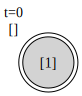

In [122]:
search = Search(1, n_p=[1], a=[], u0=[1], L_term=[0])
search.search()

search.draw()

### $ l = 2 \land L_{term} = \{0,1\} $
* $ L = \{0,1\} $
* $ | p_1 | = 10 $
* $ a $
  * a[0]: $ a_{0 \rightarrow \{1\}}$

[1, 0] [1, 0]
[1, 0.31622776601683794] [1, 0.1]
[1, 0.6324555320336759] [1, 0.4]
[1, 0.9486832980505138] [1, 0.8999999999999999]


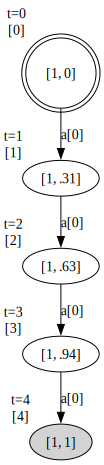

In [125]:
search = Search(2, n_p=[1, 10], a=[(0, [1])], u0=[1, 0], L_term=[0, 1])
search.search()

search.draw()

### $ l = 3 \land L_{term} = \{0,1\} $
* $ L = \{0,1,2\} $
* $ a $
  * a[0]: $ t_{0 \rightarrow \{1\}}$
  * a[1]: $ t_{0 \rightarrow \{1,2\}}$

[1, 0, 0] [1, 0, 0]
[1, 0, 0] [1, 0, 0]
[1, 0.31622776601683794, 0] [1, 0.1, 0]
[1, 0.31622776601683794, 0] [1, 0.1, 0]
[1, 0.09534625892455924, 0.09534625892455924] [1, 0.009090909090909092, 0.009090909090909092]
[1, 0.09534625892455924, 0.09534625892455924] [1, 0.009090909090909092, 0.009090909090909092]
[1, 0.6324555320336759, 0] [1, 0.4, 0]
[1, 0.6324555320336759, 0] [1, 0.4, 0]
[1, 0.41157402494139717, 0.09534625892455924] [1, 0.1693931780064618, 0.009090909090909092]
[1, 0.41157402494139717, 0.09534625892455924] [1, 0.1693931780064618, 0.009090909090909092]
[1, 0.41157402494139717, 0.09534625892455924] [1, 0.1693931780064618, 0.009090909090909092]
[1, 0.41157402494139717, 0.09534625892455924] [1, 0.1693931780064618, 0.009090909090909092]
[1, 0.19069251784911848, 0.19069251784911848] [1, 0.03636363636363637, 0.03636363636363637]
[1, 0.19069251784911848, 0.19069251784911848] [1, 0.03636363636363637, 0.03636363636363637]
[1, 0.9486832980505138, 0] [1, 0.8999999999999999, 0]
[1, 0.94

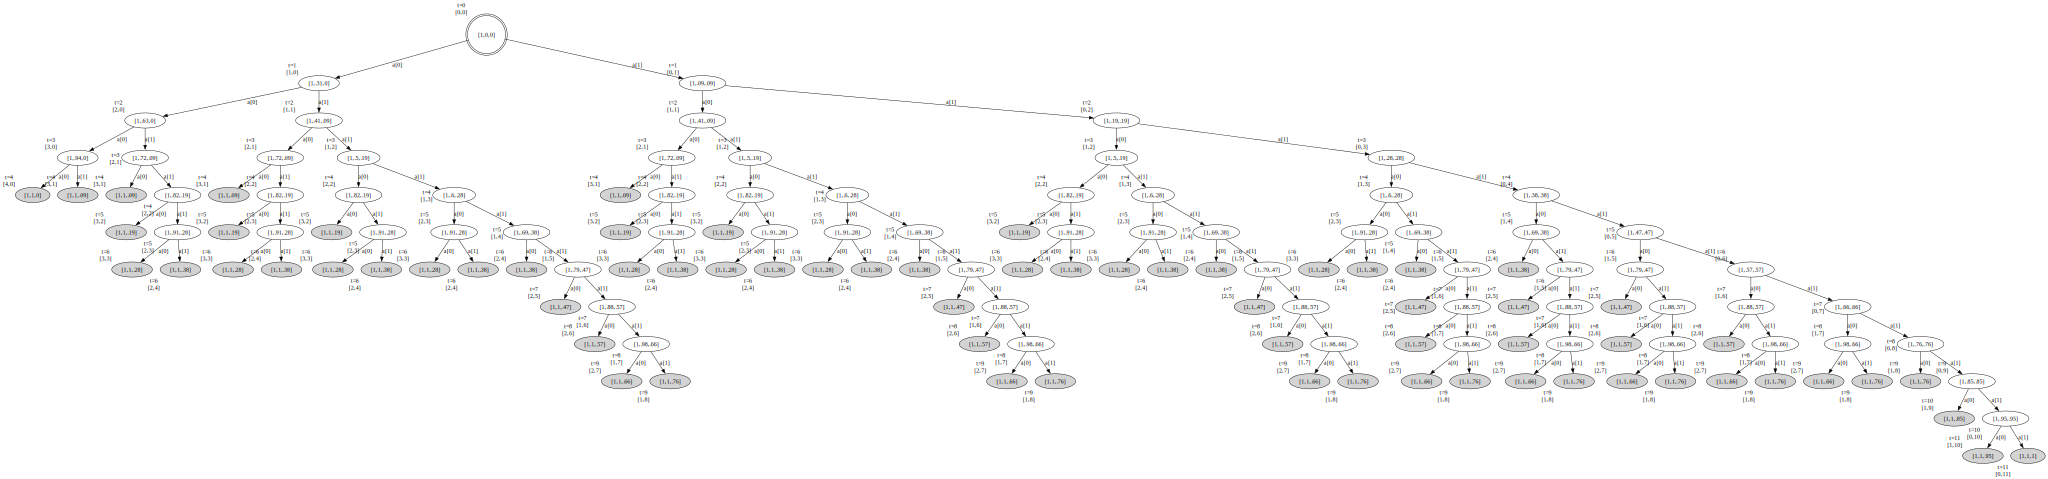

In [126]:
search = Search(3, n_p=[1, 10, 100], a=[(0, [1]), (0, [1, 2])], u0=[1, 0, 0], L_term=[0, 1])
search.search()

search.draw()

### $ l = 3 \land L_{term} = \{0,1,2\} $
* $ L = \{0,1,2\} $
* $ a $
  * a[0]: $ t_{0 \rightarrow \{1\}}$
  * a[1]: $ t_{0 \rightarrow \{1,2\}}$
  * a[2]: $ t_{1 \rightarrow \{2\}}$

#### $M_{e,linear}$ and $M_{i,addition}$

In [116]:
search = Search(3, understanding_model={"external": 'linear', "internal": 'addition'}, n_p=[1, 10, 100],
                a=[(0, [1]), (0, [1, 2]), (1, [2])],
                u0=[1, 0, 0],
                L_term=[0, 1, 2], t_max=7, term_criteria=1.0)
search.search()

search.draw()

#### $M_{e,linear}$ and $M_{i,multiplication}$

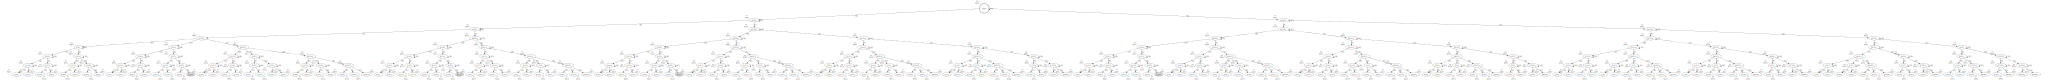

In [117]:
search = Search(3, understanding_model={"external": 'linear', "internal": 'multiplication'}, n_p=[1, 10, 100],
                a=[(0, [1]), (0, [1, 2]), (1, [2])],
                u0=[1, 0, 0],
                L_term=[0, 1, 2], t_max=7, term_criteria=1.0)
search.search()

search.draw()

#### $M_{e,square}$ and $M_{i,addition}$

In [118]:
search = Search(3, understanding_model={"external": 'square', "internal": 'addition'}, n_p=[1, 10, 100],
                a=[(0, [1]), (0, [1, 2]), (1, [2])], u0=[1, 0, 0],
                L_term=[0, 1, 2], t_max=7, term_criteria=1.0)
search.search()

search.draw()

#### $M_{e,square}$ and $M_{i,multiplication}$

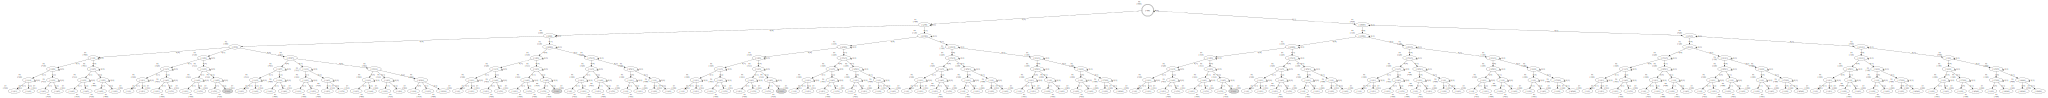

In [119]:
search = Search(3, understanding_model={"external": 'square', "internal": 'multiplication'}, n_p=[1, 10, 100],
                a=[(0, [1]), (0, [1, 2]), (1, [2])], u0=[1, 0, 0],
                L_term=[0, 1, 2], t_max=7, term_criteria=1.0)
search.search()

search.draw()